In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics


In [2]:
stockdata = pd.read_csv("stocks.csv")
stockdata.head()


,Unnamed: 0,date,open,high,low,close,volume,Name,up,down,up_ema,down_ema,RS,RSI,EMA
0,0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0.00,0.00,0.00,0.00,0.0,0.0,14.75
1,1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0.00,0.29,0.00,0.29,0.0,0.0,14.46
2,2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,0.00,0.19,0.00,0.19,0.0,0.0,14.27
3,3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.39,0.00,0.39,0.00,0.0,0.0,14.66
4,4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,0.00,0.67,0.00,0.67,0.0,0.0,13.99


In [3]:
NVDA_temp= stockdata.loc[stockdata['Name'] == 'NVDA']
del NVDA_temp['Unnamed: 0']

NVDA = pd.DataFrame(NVDA_temp[['date', 'open', 'close']]).reset_index().drop(['index'], axis = 1)
diff = []
for i in range(1259):
    diff.append(NVDA.iat[i,2] - NVDA.iat[i, 1]) 
difference = pd.DataFrame(diff, columns = ['Diff'])
NVDA_clean = pd.concat([NVDA, difference], axis = 1)
NVDA_clean.tail()



,date,open,close,Diff
1254,2018-02-01,238.52,240.50,1.98
1255,2018-02-02,237.00,233.52,-3.48
1256,2018-02-05,227.00,213.70,-13.30
1257,2018-02-06,204.40,225.58,21.18
1258,2018-02-07,229.58,228.80,-0.78


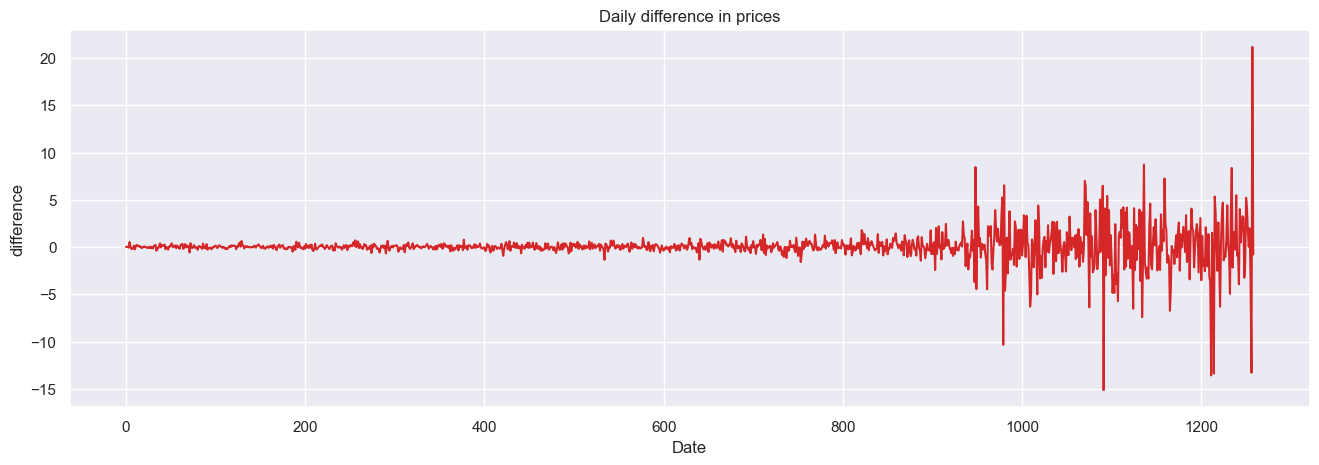

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='difference', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(NVDA_clean, x=NVDA_clean.index, y=NVDA_clean.Diff, title='Daily difference in prices')    

In [5]:
rolling_mean = difference.rolling(9).mean()
rolling_std = difference.rolling(9).std()

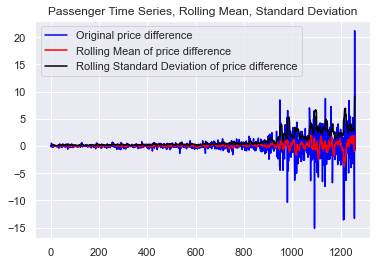

In [6]:
plt.plot(NVDA_clean.Diff, color="blue",label="Original price difference")
plt.plot(rolling_mean, color="red", label="Rolling Mean of price difference")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation of price difference")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
adft = adfuller(NVDA_clean.Diff,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -8.388985e+00              Test Statistics
1  2.395100e-13                      p-value
2  1.900000e+01             No. of lags used
3  1.239000e+03  Number of observations used
4 -3.435639e+00          critical value (1%)
5 -2.863876e+00          critical value (5%)
6 -2.568013e+00         critical value (10%)


In [9]:
autocorrelation_lag1 = NVDA_clean['Diff'].autocorr(lag=1)
print("Daily Lag:", autocorrelation_lag1)

Daily Lag: -0.16522349260628919


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

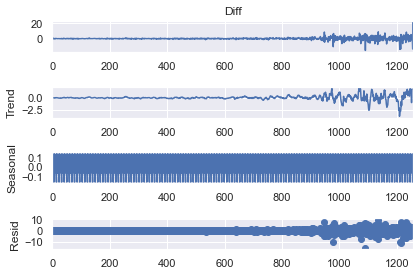

In [11]:
decompose = seasonal_decompose(NVDA_clean['Diff'],model='additive', period=9)
decompose.plot()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

train , test = train_test_split(difference, test_size = 9, shuffle = False)
test

,Diff
1250,5.21
1251,4.11
1252,1.61
1253,0.03
1254,1.98
1255,-3.48
1256,-13.30
1257,21.18
1258,-0.78


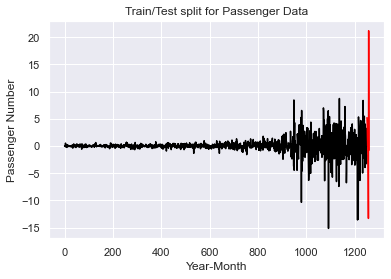

In [13]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
#sns.set()
plt.show()

In [14]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [15]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4674.878, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4706.672, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4689.042, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4689.887, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4705.463, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4690.772, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4692.142, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4685.526, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4691.017, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4683.654, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4683.564, Time=0.30 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=4678.029, Time=1.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4673.749, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : 

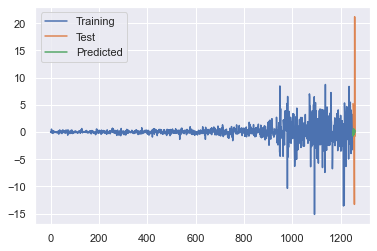

In [16]:
plt.plot(train, label = "Training")
plt.plot(test,label="Test")
plt.plot (forecast, label="Predicted")
plt.legend (loc = "best")
plt.show()

In [17]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  8.667697846647368


In [18]:
from sklearn.metrics import r2_score
test['prediction'] = forecast
r2_score(test['Diff'], test['prediction'])

/var/folders/s8/7g696tq143v3j0l1f7n99z7c0000gn/T/ipykernel_34521/3739257772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = forecast


-0.027162397128910776

In [19]:
test_bool = []
forecast_bool = []
for i in range(9):
 if (test.iat[i,0] >= 0):
    test_bool.append(True)
 else:
    test_bool.append(False)
for i in range(9):
 if (test.iat[i,1] >= 0):
    forecast_bool.append(True)
 else:
    forecast_bool.append(False)
print(test_bool)
print(forecast_bool)

[True, True, True, True, True, False, False, True, False]
[True, False, False, True, True, False, True, True, False]
